# Genetik Algoritma ile Metin Sınıflandırma
Bu çalışmada genetik algoritma kullanılarak 2 sınıflı 500 örnek içeren Amazon yorumları veri kümesi ile metin sınıflandırma yapılmıştır.

In [1]:
import random
import string

import math
import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
file='amazonCellsLabeled.csv'
class1 = 1
class2 = 0
wordFrequencyMin = 5
wordFrequencyMax = 50

## Data Pre-processing
Bu kısımda kullanılacak olan kelime deposu, cümleleri ve classları içeren dictionary yapısı oluşturuldu.

In [3]:
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [4]:
df= pd.read_csv(file,header=None,names=['Sentences','Classes'])
df.head()

,Sentences,Classes
0,This is by far the worst purchase I've made on...,0
1,Excellent starter wireless headset.,0
2,It is a joy to use.,1
3,Trying to make a call on these is an exercise ...,0
4,Just reading on the specs alone makes you say ...,1


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Classes,500.0,0.512,0.500357,0.0,0.0,1.0,1.0,1.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentences  500 non-null    object
 1   Classes    500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


rstrip methodu ile cümle sonlarındaki noktalama işaretleri temizlendi ve lower methodu ile cümledeki tüm karakterler küçük harfe çevrildi.

In [7]:
df['Sentences'] = df['Sentences'].apply(lambda x: x.rstrip(string.punctuation).lower())

In [8]:
df.sample(5)

,Sentences,Classes
438,it's really easy,1
366,very comfortable,1
446,the one big drawback of the mp3 player is that...,0
358,it is practically useless and did not add any ...,0
232,price is good too,1


Dataframedeki cümle ve class sütunları daha rahat arama yapabilmek için sentencesAndClasses dictionary yapısına dönüştürüldü.

In [9]:
sentencesAndClasses = dict(zip(df['Sentences'], df['Classes']))
numberOfSentences = len(sentencesAndClasses)
sentencesAndClasses

{"this is by far the worst purchase i've made on amazon": 0,
 'excellent starter wireless headset': 0,
 'it is a joy to use': 1,
 'trying to make a call on these is an exercise in frustration': 0,
 'just reading on the specs alone makes you say wow': 1,
 'this product had a strong rubber/petroleum smell that was unbearable after a while and caused me to return it': 0,
 'it has been a winner for us': 1,
 'the nokia ca-42 usb cable did not work with my phone': 0,
 'i would highly recommend this product': 1,
 'the sound quality is good and functionality is awesome': 1,
 'linksys should have some way to exchange a bad phone for a refurb unit or something': 0,
 "that one didn't work either": 0,
 'nice headphones for the price and they work great': 1,
 'amazon sucks': 0,
 'logitech bluetooth headset is a 10': 1,
 'excellent sound quality': 1,
 'nice sound': 1,
 'motorola finally got the voice quality of a bluetooth headset right': 1,
 "also difficult to put on.i'd recommend avoiding this pro

Popülasyondaki bireylere atama yapılmak üzere dataframedeki kelimeler, frekanslarıyla birlikte words isimli dictionary yapısına alındı.

In [10]:
words = {}
for sentence in sentencesAndClasses.keys():
    sentence = sentence.split(" ")
    for word in sentence:
        if word in words:
            words[word] += 1
        else:
            words[word] = 1
print(f'Lenght of words = {len(words)}')

Lenght of words = 1160


Çok sık ya da çok az geçmiş kelimeler elenerek bireylere atama yapacağımız asıl kelime deposu oluşturuldu.

In [11]:
dictionary = {}
for w in words:
    if wordFrequencyMin <= words[w] <= wordFrequencyMax:
        dictionary[w] = words[w]
print(f'Lenght of dictionary = {len(dictionary)}')

Lenght of dictionary = 148


## Genetik Algoritma
Bu kısımda yapılan işlemler şunlardır:
- Başlangıç popülasyonu oluşturuldu.
- Fitness fonksiyonu yazıldı.
- Seçilme şansına göre üyeler gelecek nesili oluşturmak için seçildi.
- Seçilen üyeler ikili eşleştirilerek cross over işlemine tâbi tutuldu.
- Cross over sonrası mutasyon oranlarına göre bireylerde kelime değişiklikleri gerçekleştirildi.

In [12]:
def createInitialPopulation(populationSize,lengthOfPopulationMember):
    """
        Dictionaryden birey uzunluğu kadar unique random değerler alınır ve bireyler oluşturulur.
        Bu bireyler daha sonra population isimli diziye eklenir.
        Parametreler:
            populationSize: Popülasyonun büyüklüğü
            lengthOfPopulationMember: Popülasyonun bir bireyinin içerdiği kelime sayısı
        Dönüş değerleri:
            population = Bireyleri tutan nested list yapısı
    """
    population = []
    for _ in range(populationSize):
        member = random.sample(list(dictionary.keys()), lengthOfPopulationMember)
        population.append(member)
    return population

In [13]:
def fitnessScore(member,lengthOfPopulationMember, sentencesAndClasses):
    """
        Verilen bireydeki kelimelerle dataframedeki cümlelerdeki ortak kelimelere bakarak skor hesaplanır.
        Bu skor hesaplanırken bireyin ilk yarısı pozitif kısım, son yarısı negatif kısım olarak alınmıştır.
        Eğer skor pozitifse ve cümle de pozitif etiketlenmişse ya da skor negatifse ve cümle negatif etiketlenmişse,
        genel tahmin bir arttırılır.
        Dönüş değerinde, genel tahminin dataframedeki cümle sayısına göre yüzdesi döndürülür.
        Parametreler:
            member = Popülasyona ait bir bireyi tutan list yapısı
            sentencesAndClasses = Dataframedeki cümle ve etiketleri tutan dictionary yapısı
            lengthOfPopulationMember: Popülasyonun bir bireyinin içerdiği kelime sayısı
        Dönüş değerleri:
            totalCorrectGuess yüzdesi
    """
    totalCorrectGuess = 0
    positiveSide = member[:int(lengthOfPopulationMember/2)]
    negativeSide = member[-int(lengthOfPopulationMember/2):]
    for sentence in sentencesAndClasses.keys():
        words = sentence.split()
        score = 0
        score += len(set(positiveSide).intersection(set(words)))
        score -= len(set(negativeSide).intersection(set(words)))
        if score > 0 and sentencesAndClasses[sentence] == class1:
            totalCorrectGuess += 1
        elif score <= 0 and sentencesAndClasses[sentence] == class2:
            totalCorrectGuess += 1
    return totalCorrectGuess / len(sentencesAndClasses) * 100

In [14]:
def selectMember(population, fitnessScores, populationSize):
    """
        Fitness skorlarını standardilize edip yüzdesini alarak bireylerin seçilme şansları bulunur.
        Bu seçilme şansları kullanılarak yeni jenerasyon için cross over yapılacak bireyler, ata bireylerden seçilir.
        Parametreler:
            population = Bireyleri tutan nested list yapısı
            fitnessScores = Bireylerin doğru tahmin yüzdesini tutan list yapısı
            populationSize = Popülasyondaki birey sayısı
        Dönüş değerleri:
            selectedMembers = Cross over işlemine girecek bireyleri tutan nested list yapısı
    """
    standardizedScores = np.abs(fitnessScores - np.mean(fitnessScores)) / np.std(fitnessScores)
    chanceForBeingSelected = standardizedScores / sum(standardizedScores) * 100
    selectedMembers = []
    for i in range(populationSize):
        selected_index = random.choices(range(len(population)), weights=chanceForBeingSelected)[0]
        selectedMembers.append(population[selected_index])
    return selectedMembers

In [15]:
def crossOver(populationForCrossOver, populationSize,lengthOfPopulationMember):
    """
        Art arda gelen iki bireyin kelimelerini verilen cross over noktasına göre değiş tokuş yapar.
        Oluşan yeni bireyleri newPopulation isimli liste ekler.
        Parametreler:
            populationForCrossOver = Seçilen üyeleri tutan nested list yapısı (selectMember fonksiyonunun dönüş değeri)
            populationSize: Popülasyonun büyüklüğü
            lengthOfPopulationMember: Popülasyonun bir bireyinin içerdiği kelime sayısı
        Dönüş değerleri:
            newPopulation = Mutasyon işlemine gönderilecek nested list yapısı
    """
    newPopulation = []
    for i in range(0, populationSize, 2):
        crossOverPoint = int(lengthOfPopulationMember*(random.uniform(0.3, 0.5)))    # Bireylerin kırpılacak noktasını belirten integer değer

        parent1CroppedPart = ' '.join(populationForCrossOver[i][-crossOverPoint:])
        parent2CroppedPart = ' '.join(populationForCrossOver[i+1][-crossOverPoint:])
        
        child1 = populationForCrossOver[i][:-crossOverPoint] + parent2CroppedPart.split()
        child2 = populationForCrossOver[i+1][:-crossOverPoint] + parent1CroppedPart.split()
        
        newPopulation.append(child1)
        newPopulation.append(child2)
    return newPopulation

In [16]:
def mutatingPopulation(lengthOfPopulationMember, populationForMutation, dictionary, numberOfMembersToMutate,numberOfGenesToBeChanges):
    """
        Mutasyona uğrayacak birey sayısı kadar bireyleri seçer.
        Mutasyona uğrayacak kelime sayısı kadar seçilen bireyler içerisinde kelimeleri değiştirir.
        Parametreler:
            lengthOfPopulationMember: Popülasyonun bir bireyinin içerdiği kelime sayısı
            populationForMutation = Bireyleri tutan nested list yapısı (crossOver fonksiyonunun dönüş değeri)
            dictionary = Kelime deposunu tutan dictionary yapısı
            numberOfMembersToMutate = Mutasyona uğrayacak birey sayısı
            numberOfGenesToBeChanges = Tek bir bireyin mutasyona uğrayacak kelime sayısı
        Dönüş değerleri:
            populationForMutation = Bireyleri tutan nested list yapısı (Mutasyondan sonra)
    """
    selectedMembersIndices = random.sample(range(len(populationForMutation)), numberOfMembersToMutate)
    for i in selectedMembersIndices:
        indexesOfGensToChange = random.sample(range(lengthOfPopulationMember),numberOfGenesToBeChanges)
        for j in indexesOfGensToChange:
            newWord = random.choice(list(dictionary.keys()))
            oldWord = populationForMutation[i][j]
            populationForMutation[i][j] = newWord
    return populationForMutation

#### ÖNEMLİ!
Aşağıdaki kod bloğu iterasyon sayısı 500, birey uzunluğu 10, birey sayısı 50 olduğunda 1,5 dakika ile 2 dakika arası çalışmaktadır

In [17]:
def generationProduction(populationSize, lengthOfPopulationMember, generationNumber, rateOfNumberOfMembersToMutate, rateOfNumberOfGenesToBeChanges):
    """
        Yukarıda tanımları yapılan
            -createInitialPopulation
            -fitnessScore
            -selectMember
            -crossOver
            -mutatingPopulation fonksiyonlarını kullanarak jenerasyon sayısınca jenerasyon üreten genel bir fonksiyondur.
        Aynı zamanda 
            -tüm jenerasyonların tüm bireylerinin fitness değerlerlerini
            -tüm jenerasyonların en iyi fitness değerine sahip bireyini 
            -tüm jenerasyonlara ait ortalama fitness değerini tutan diziler bu fonksiyonda doldurulur.
        Parametreler:
            populationSize: Popülasyonun büyüklüğü
            lengthOfPopulationMember: Popülasyonun bir bireyinin içerdiği kelime sayısı
            generationNumber: Oluşturulacak jenerasyon sayısı
            rateOfNumberOfMembersToMutate: Mutasyona uğratılacak birey sayısı
            rateOfNumberOfGenesToBeChanges: Mutasyona uğratılacak gen sayısı
        Dönüş değerleri:
            fitnessValuesForGenerations: Tüm jenerasyonların tüm bireylerine fitness değerlerini tutar
            bestOfPopulations: Tüm jenerasyonların en iyi fitness değerine sahip bireyini tutar
            meanOfPopulations: Tüm jenerasyonlara ait ortalama fitness değerini tutar
    """
    fitnessValuesForGenerations = []   #Tüm jenerasyonların tüm bireylerine fitness değerlerini tutar 
    bestOfPopulations = []             #Tüm jenerasyonların en iyi fitness değerine sahip bireyini tutar  
    meanOfPopulations = []             #Tüm jenerasyonlara ait ortalama fitness değerini tutar      


    # İlk jenerasyon atanır
    currentGeneration = createInitialPopulation(populationSize,lengthOfPopulationMember)

    # Jenerasyon sayısına göre for döngüsü
    for i in range(generationNumber):

        # Bireyleri ve skorları tutacak dataframe yapısı (tekrarlı value izin vermediği için dict veri tipi kullanılmamıştır)
        fScores = pd.DataFrame(columns=["Members", "Scores"])

        # Jenerasyondaki tüm bireylerin fitness değeri hesaplanır ve dataframe yapısının sonuna eklenir
        for member in currentGeneration:
         fScores.loc[len(fScores.index)] = [member, fitnessScore(member,lengthOfPopulationMember, sentencesAndClasses)]
    
        # Jenerasyonun ortalama fitness değeri kaydedilir
        meanOfPopulationMembersScores = sum(fScores["Scores"]) / populationSize
        meanOfPopulations.append(meanOfPopulationMembersScores)

        # Jenerasyon ve en iyi birey kaydedilir
        fitnessValuesForGenerations.append(fScores.values.tolist())
        bestMember = fScores.iloc[fScores['Scores'].idxmax()].to_list()
        bestOfPopulations.append(bestMember)

        selectedMembers = selectMember(currentGeneration, list(fScores["Scores"]), populationSize)     # Birey seçme
        membersAfterCrossOver = crossOver(selectedMembers, populationSize, lengthOfPopulationMember)                          # Crossing over

        # Mutasyondan önce orana göre mutasyona uğrayacak kelime ve birey sayısı hesaplanır
        numberOfMembersToMutate = int(populationSize*(rateOfNumberOfMembersToMutate))
        numberOfGenesToBeChanges = int(lengthOfPopulationMember*(rateOfNumberOfGenesToBeChanges))
        currentGeneration = mutatingPopulation(lengthOfPopulationMember, membersAfterCrossOver, dictionary, numberOfMembersToMutate, numberOfGenesToBeChanges) # Mutasyon

        #Fonksiyonun ilk 3 satırında bahsi geçen 3 dizi dönüş değeri olarak döndürülür.
    return fitnessValuesForGenerations, bestOfPopulations, meanOfPopulations


In [18]:
fitnessValuesForGenerations, bestOfPopulations, meanOfPopulations = generationProduction(populationSize=100, lengthOfPopulationMember=50, generationNumber=100,
                                                                                        rateOfNumberOfMembersToMutate=0.4, rateOfNumberOfGenesToBeChanges=0.5)

In [19]:
def plotFitnessValues(percentages, generationNumber, title):
    plt.plot(range(generationNumber), percentages) # Çizgi grafiği oluştur
    plt.xlabel('Jenerasyonlar')
    plt.ylabel('Fitness Değerleri')
    plt.title(title)
    plt.show()

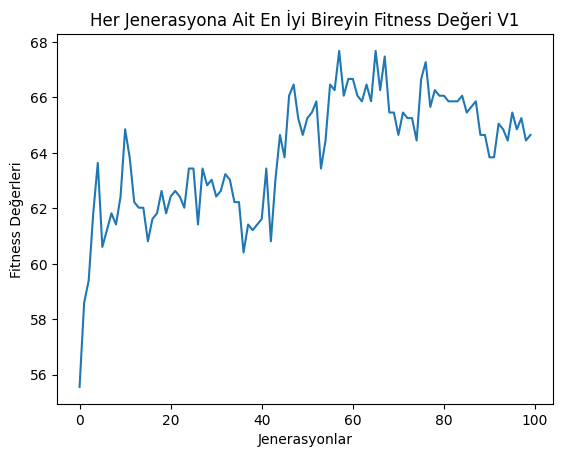

En iyi birey: 		['no', 'well', 'quality', 'too', 'as', 'they', 'good', 'excellent', 'price', 'works', 'few', 'well', 'price', 'also', "it's", "i'm", 'up', 'everything', 'service', 'received', 'off', 'no', 'would', 'all', 'great', 'work', 'have', 'long', "it's", 'because', 'am', 'when', 'used', 'them', 'while', 'they', 'bluetooth', 'there', 'while', 'buy', 'best', 'first', 'buy', 'big', 'them', 'first', 'into', 'few', 'worst', 'then']

En iyi ikinci birey:	['no', 'well', 'quality', 'too', 'as', 'they', 'good', 'excellent', 'price', 'works', 'few', 'well', 'price', 'also', "it's", "i'm", 'up', 'everything', 'service', 'received', 'off', 'no', 'would', 'all', 'great', 'work', 'bad', 'item', 'at', 'before', 'nice', 'poor', 'used', 'them', 'while', 'they', 'bluetooth', 'there', 'while', 'buy', 'best', 'first', 'buy', 'big', 'them', 'first', 'into', 'few', 'worst', 'then']

En iyi üçüncü birey:	['no', 'well', 'quality', 'too', 'as', 'they', 'good', 'excellent', 'price', 'works', 'few', 'well

In [20]:
percentages = [member[1] for member in bestOfPopulations]
plotFitnessValues(percentages, generationNumber=100, title='Her Jenerasyona Ait En İyi Bireyin Fitness Değeri V1')

threeBestOfAll = np.array(percentages).argsort()[-3:]
print(f"En iyi birey: \t\t{bestOfPopulations[threeBestOfAll[0]][0]}\n")
print(f"En iyi ikinci birey:\t{bestOfPopulations[threeBestOfAll[1]][0]}\n")
print(f"En iyi üçüncü birey:\t{bestOfPopulations[threeBestOfAll[2]][0]}\n")

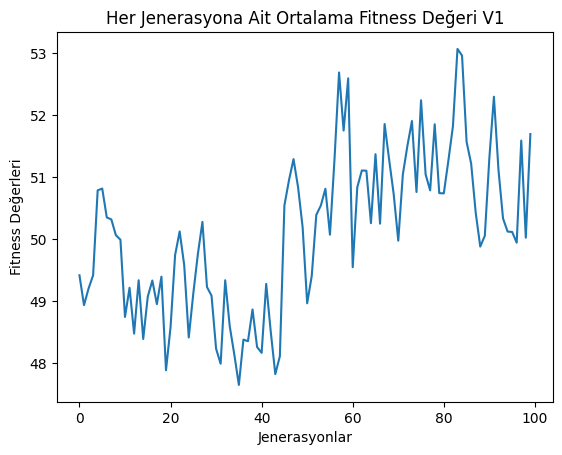

In [21]:
plotFitnessValues(meanOfPopulations, generationNumber=100, title='Her Jenerasyona Ait Ortalama Fitness Değeri V1')

In [22]:
def selectMemberV2(pastPopulation, currentPopulation, populationSize):
    """
        Daha iyi jenerasyon üretmek adına ata bireylerden de belli bir oranda birey seçimi yapmamızı sağlayan fonksiyon.
        Her jenerasyon kendinden önceki 2 jenerasyonun en iyi bireylerinin birleşimiyle oluşur. 
        Yani son 2 jenerasyon seçildiği için seçim şekli fibonacci dizisine benzemektedir. 
        Popülasyon bireylerinin sayısı sabit tutulmuştur.
        Kalan işlemler selectMemberV1 fonksiyonu ile aynı olup aşağıdaki gibidir:
        Fitness skorlarını standartize edip yüzdesini alarak bireylerin seçilme şansları bulunur.
        Bu seçilme şansları kullanılarak yeni jenerasyon için cross over yapılacak bireyler, ata bireylerden seçilir.
        Parametreler:
            pastPopulation = Oluşacak jenerasyonun 2 jenerasyon öncesi
            currentPopulation = Oluşacak jenerasyonun 1 jenerasyon öncesi
            populationSize = Popülasyondaki birey sayısı
        Dönüş değerleri:
            selectedMembers = Cross over işlemine girecek bireyleri tutan nested list yapısı
    """
    pastPopulation = pd.DataFrame(pastPopulation, columns= ["Members", "Scores"])
    currentPopulation = pd.DataFrame(currentPopulation, columns= ["Members", "Scores"])
    pastPopulationTops = pastPopulation.nlargest(math.floor(populationSize/3), "Scores")
    currentPopulationTops = pastPopulation.nlargest((populationSize - len(pastPopulationTops)), "Scores")
    mergedTops = pd.concat([pastPopulationTops, currentPopulationTops])
    fitnessScores = list(mergedTops["Scores"])
    population = list(mergedTops["Members"])
    standardizedScores = np.abs(fitnessScores - np.mean(fitnessScores)) / np.std(fitnessScores)
    chanceForBeingSelected = standardizedScores / sum(standardizedScores) * 100
    selectedMembers = []
    for i in range(populationSize):
        selected_index = random.choices(range(len(population)), weights=chanceForBeingSelected)[0]
        selectedMembers.append(population[selected_index])
    return selectedMembers

In [23]:
def generationProductionV2(populationSize, lengthOfPopulationMember, generationNumber, rateOfNumberOfMembersToMutate, rateOfNumberOfGenesToBeChanges):
    """
        Yukarıda tanımları yapılan
            -createInitialPopulation
            -fitnessScore
            -selectMember
            -crossOver
            -mutatingPopulation fonksiyonlarını kullanarak jenerasyon sayısınca jenerasyon üreten genel bir fonksiyondur.
        Aynı zamanda 
            -tüm jenerasyonların tüm bireylerinin fitness değerlerlerini
            -tüm jenerasyonların en iyi fitness değerine sahip bireyini 
            -tüm jenerasyonlara ait ortalama fitness değerini tutan diziler bu fonksiyonda doldurulur.
        Parametreler:
            populationSize: Popülasyonun büyüklüğü
            lengthOfPopulationMember: Popülasyonun bir bireyinin içerdiği kelime sayısı
            generationNumber: Oluşturulacak jenerasyon sayısı
            rateOfNumberOfMembersToMutate: Mutasyona uğratılacak birey sayısı
            rateOfNumberOfGenesToBeChanges: Mutasyona uğratılacak gen sayısı
        Dönüş değerleri:
            fitnessValuesForGenerations: Tüm jenerasyonların tüm bireylerine fitness değerlerini tutar
            bestOfPopulations: Tüm jenerasyonların en iyi fitness değerine sahip bireyini tutar
            meanOfPopulations: Tüm jenerasyonlara ait ortalama fitness değerini tutar
    """
    fitnessValuesForGenerations = []   #Tüm jenerasyonların tüm bireylerine fitness değerlerini tutar 
    bestOfPopulations = []             #Tüm jenerasyonların en iyi fitness değerine sahip bireyini tutar  
    meanOfPopulations = []             #Tüm jenerasyonlara ait ortalama fitness değerini tutar      


    # İlk jenerasyon atanır
    currentGeneration = createInitialPopulation(populationSize,lengthOfPopulationMember)
    fScores = pd.DataFrame(columns=["Members", "Scores"])
    for member in currentGeneration:
         fScores.loc[len(fScores.index)] = [member, fitnessScore(member,lengthOfPopulationMember, sentencesAndClasses)]    
    fitnessValuesForGenerations.append(fScores.values.tolist())
    
    # Jenerasyon sayısına göre for döngüsü
    for i in range(generationNumber):

        # Bireyleri ve skorları tutacak dataframe yapısı (tekrarlı value izin vermediği için dict veri tipi kullanılmamıştır)
        fScores = pd.DataFrame(columns=["Members", "Scores"])

        # Jenerasyondaki tüm bireylerin fitness değeri hesaplanır ve dataframe yapısının sonuna eklenir
        for member in currentGeneration:
         fScores.loc[len(fScores.index)] = [member, fitnessScore(member,lengthOfPopulationMember, sentencesAndClasses)]
    
        # Jenerasyonun ortalama fitness değeri kaydedilir
        meanOfPopulationMembersScores = sum(fScores["Scores"]) / populationSize
        meanOfPopulations.append(meanOfPopulationMembersScores)

        # Jenerasyon ve en iyi birey kaydedilir
        fitnessValuesForGenerations.append(fScores.values.tolist())
        bestMember = fScores.iloc[fScores['Scores'].idxmax()].to_list()
        bestOfPopulations.append(bestMember)

        selectedMembers = selectMemberV2(fitnessValuesForGenerations[-2], fitnessValuesForGenerations[-1], populationSize)     # Birey seçme
        membersAfterCrossOver = crossOver(selectedMembers, populationSize,lengthOfPopulationMember)                          # Crossing over

        # Mutasyondan önce orana göre mutasyona uğrayacak kelime ve birey sayısı hesaplanır
        numberOfMembersToMutate = int(populationSize*(rateOfNumberOfMembersToMutate))
        numberOfGenesToBeChanges = int(lengthOfPopulationMember*(rateOfNumberOfGenesToBeChanges))
        currentGeneration = mutatingPopulation(lengthOfPopulationMember, membersAfterCrossOver, dictionary, numberOfMembersToMutate, numberOfGenesToBeChanges) # Mutasyon

        #Fonksiyonun ilk 3 satırında bahsi geçen 3 dizi dönüş değeri olarak döndürülür.
    return fitnessValuesForGenerations, bestOfPopulations, meanOfPopulations


In [24]:
fitnessValuesForGenerations2, bestOfPopulations2, meanOfPopulations2 = generationProductionV2(populationSize=100, lengthOfPopulationMember=50, generationNumber=100,
                                                                                        rateOfNumberOfMembersToMutate=0.4, rateOfNumberOfGenesToBeChanges=0.5)

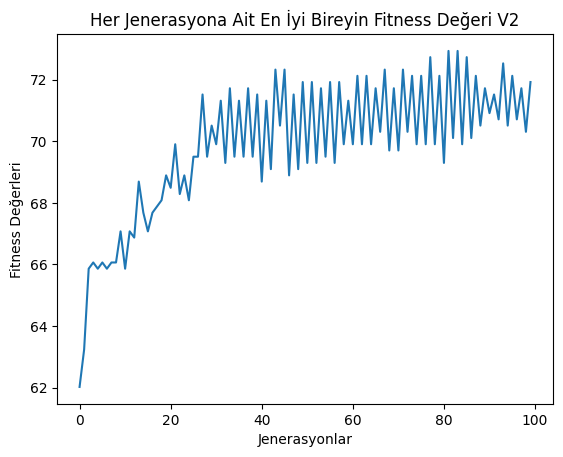

En iyi birey: 		['long', 'talk', 'new', 'happy', 'up', 'big', 'right', 'with', 'excellent', 'great', 'voice', 'much', 'all', 'talk', 'thing', 'but', 'plug', 'headset', 'if', 'good', 'comfortable', 'works', "it's", 'disappointed', 'recommend', 'made', 'if', 'be', 'software', 'how', 'bad', 'buy', 'even', 'there', 'not', 'nice', 'even', 'be', 'after', 'time', 'nice', 'volume', 'than', 'thing', 'they', 'received', 'did', 'could', 'better', 'had']

En iyi ikinci birey:	['long', 'talk', 'new', 'happy', 'up', 'big', 'right', 'with', 'excellent', 'great', 'voice', 'much', 'all', 'talk', 'thing', 'but', 'plug', 'headset', 'if', 'good', 'comfortable', 'works', "it's", 'disappointed', 'recommend', 'made', 'if', 'be', 'software', 'how', 'bad', 'buy', 'also', 'there', 'not', 'nice', 'even', 'be', 'after', 'time', 'nice', 'volume', 'than', 'thing', 'they', 'received', 'did', 'could', 'better', 'had']

En iyi üçüncü birey:	['long', 'talk', 'new', 'happy', 'up', 'big', 'right', 'with', 'excellent', 'g

In [25]:
percentages = [member[1] for member in bestOfPopulations2]
plotFitnessValues(percentages, generationNumber=100, title='Her Jenerasyona Ait En İyi Bireyin Fitness Değeri V2')

threeBestOfAll = np.array(percentages).argsort()[-3:]
print(f"En iyi birey: \t\t{bestOfPopulations2[threeBestOfAll[0]][0]}\n")
print(f"En iyi ikinci birey:\t{bestOfPopulations2[threeBestOfAll[1]][0]}\n")
print(f"En iyi üçüncü birey:\t{bestOfPopulations2[threeBestOfAll[2]][0]}\n")

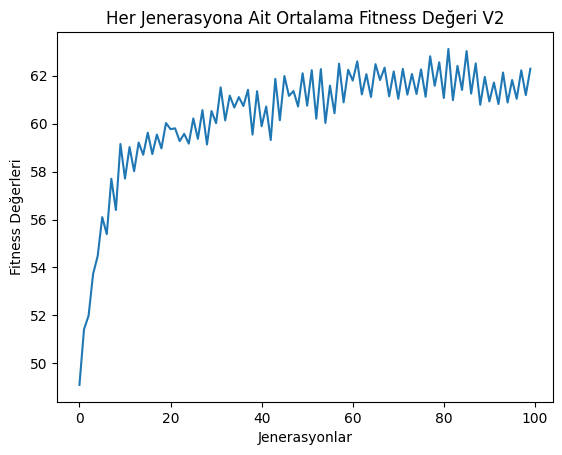

In [26]:
plotFitnessValues(meanOfPopulations2, generationNumber=100, title='Her Jenerasyona Ait Ortalama Fitness Değeri V2')

## Test Etmek İsterseniz :)

In [27]:
def testModel(sentence):
    maxIndex = percentages.index(max(percentages))
    member = bestOfPopulations[maxIndex][0]
    print(f"Kullanılan member: {member}")
    words = sentence.split()
    positiveSide = member[:int(len(member)/2)]
    negativeSide = member[-int(len(member)/2):]
    score = 0
    score += len(set(positiveSide).intersection(set(words)))
    score -= len(set(negativeSide).intersection(set(words)))
    if (score > 0):
        return "İlk sınıf"
    return "İkinci sınıf"

In [29]:
sentence = "I hate this product. It's totally useless."
testModel(sentence)

Kullanılan member: ['no', 'well', 'quality', 'too', 'as', 'they', 'good', 'excellent', 'price', 'works', 'few', 'well', 'price', 'also', "it's", "i'm", 'up', 'everything', 'service', 'received', 'off', 'no', 'would', 'all', 'great', 'work', 'had', 'sturdy', 'again', 'just', 'device', 'used', 'right', 'ever', 'worst', 'disappointed', 'could', 'them', 'life', 'happy', 'if', 'work', 'out', 'or', 'was', 'everything', 'them', 'small', 'up', 'ever']


'İkinci sınıf'